<h1 align='center'>Study Buddy</h1>

## Installing Dependencies

In [1]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_ollama import OllamaEmbeddings, ChatOllama
import weaviate
from weaviate.classes.config import Property, DataType, Configure

from pinecone import Pinecone
import config

import json
import os

c:\Users\Utkarsh\Documents\Projects\Study-Buddy\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Connecting to the DBs and servers

#### Loading User Profile

In [2]:
USER_PROFILE_FILE = "user_profile.json"

def load_user_profile():
    if not os.path.exists(USER_PROFILE_FILE):
        return {"name": None}
    try:
        with open(USER_PROFILE_FILE, "r", encoding="utf-8") as f:
            return json.load(f)
    except json.JSONDecodeError:
        return {"name": None}
    
def save_user_profile(profile_data):
    with open(USER_PROFILE_FILE, "w", encoding="utf-8") as f:
        json.dump(profile_data, f, indent=2)

In [3]:
# ===== A. Weaviate (for Episodic Memory) =====

try:
    vdb_client = weaviate.connect_to_local()
    print("Connected to Weaviate: ", vdb_client.is_ready())
except Exception as e:
    print(f"Could not connect to Weaviate. Is it running? \nError: {e}")

Connected to Weaviate:  True


In [4]:
# vdb_client.collections.delete("episodic_memory")

In [5]:
# ===== B. Pinecone (for Semantic Memory) =====

pc = Pinecone(api_key=config.PINECONE_API_KEY)
pinecone_index = pc.Index(config.PINECONE_INDEX_NAME)
print(f"Connected to Pinecone Index: {config.PINECONE_INDEX_NAME}")
print(pinecone_index.describe_index_stats())

Connected to Pinecone Index: study-buddy-768
{'dimension': 768,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 71}},
 'total_vector_count': 71,
 'vector_type': 'dense'}


In [6]:
# ===== C. NVIDIA Client (for Semantic Embeddings and LLM) =====

OLLAMA_EMBED_MODEL = "nomic-embed-text:latest"
OLLAMA_CHAT_MODEL = "gpt-oss:20b-cloud"
OLLAMA_API_ENDPOINT = "http://host.docker.internal:11434"

# This LLM is for *chat and reflection*
llm = ChatOllama(model=OLLAMA_CHAT_MODEL, temperature=0.7)
print(f"ChatOllama initialized with model: {OLLAMA_CHAT_MODEL}")

# This embedder is for *querying Pinecone*
embedding_model = OllamaEmbeddings(model=OLLAMA_EMBED_MODEL)
print(f"OllamaEmbeddings initialized with model: {OLLAMA_EMBED_MODEL}")

ChatOllama initialized with model: gpt-oss:20b-cloud
OllamaEmbeddings initialized with model: nomic-embed-text:latest


## Helper Functions

In [7]:
# ===== "STUDY BUDDY" REFLECTION PROMPT =====

reflection_prompt_template = """
You are an AI assistant analyzing a study session with a student. 
Your task is to create a memory that will help you be a better "STUDY-BUDDY" in the future.

Review the conversation and create a memory reflection following these rules:
1. For any field where you don't have enough information, use "N/A".
2. Be extremely concise.
3. Focus *only* on the user's learning, knowledge gaps, and preferences.

Output valid JSON in exactly this format:
{{
    "context_tags": [              // 2-4 keywords about the general topic (e.g., "calculus", "keynesian_economics")
        string,
        ...
    ],
    "conversation_summary": string, // One sentence describing what the conversation accomplished (e.g., "User was quizzed on Chapter 2 and struggled with 'opportunity cost'.")
    "identified_weak_topics": [    // Specific concepts or topics the user was confused about or answered incorrectly.
        string,                    // e.g., "Opportunity Cost", "Derivative of sin(x)"
        ...
    ],
    "identified_strong_topics": [  // Specific concepts the user understood well or answered correctly.
        string,
        ...
    ],
    "user_learning_preference": string, // Any observed preferences (e.g., "Prefers multiple-choice questions", "Responds well to mnemonics", "N/A"),
    "user_name": string // e.g., "Utkarsh" or "N/A" if not mentioned or confirmed
}}

Do not include any text outside the JSON object in your response.

Here is the prior conversation:

{conversation}
"""

reflection_prompt = ChatPromptTemplate.from_template(reflection_prompt_template)
reflect = reflection_prompt | llm | JsonOutputParser()

In [8]:
# ===== FORMAT CONVERSATION HELPER =====

def format_conversation(messages):
    conversation = []
    for message in messages:
        # This robustly skips any non-message objects that might be in the list
        if not hasattr(message, 'type') or not hasattr(message, 'content'):
            continue

        # Skip the initial large system/semantic prompts for a cleaner reflection
        if message.type == "system":
            continue
        if "Use this grounded context" in message.content:
            continue
            
        conversation.append(f"{message.type.upper()}: {message.content}")
    
    return "\n".join(conversation)

In [9]:
# # ===== RETRIEVAL FUNCTIONS =====

# # === A. EPISODIC RECALL ===
# def episodic_recall(query, vdb_client):
#     try:
#         episodic_memory = vdb_client.collections.get("episodic_memory")
#     except Exception as e:
#         print(f"Error getting episodic_memory collection: {e}")
#         print("Attempting to create 'episodic_memory' collection...")
#         # If the collection doesn't exist, create it.
#         # This is a simple setup. You might want to configure vectors explicitly.
#         episodic_memory = vdb_client.collections.create(name="episodic_memory")
        
#         # Add a dummy entry so the first query doesn't fail
#         episodic_memory.data.insert({
#             "conversation": "USER: Hello\nAI: Hi! Welcome to STUDY-BUDDY.",
#             "context_tags": ["initial_setup"],
#             "conversation_summary": "Initial conversation setup.",
#             "identified_weak_topics": ["N/A"],
#             "identified_strong_topics": ["N/A"],
#             "user_learning_preference": "N/A"
#         })
#         print("Collection 'episodic_memory' created with a dummy entry.")

#     memory = episodic_memory.query.hybrid(
#         query=query,
#         alpha=0.5,
#         limit=1,
#     )
    
#     # Handle case where memory is empty
#     if not memory.objects:
#         # This can happen on the very first run if creation fails or is slow
#         print("No episodic memory found. Using default.")
#         return {
#             "conversation": "N/A",
#             "identified_weak_topics": ["N/A"],
#             "identified_strong_topics": ["N/A"],
#             "user_learning_preference": "N/A"
#         }
    
#     return memory.objects[0].properties

In [10]:
# ===== RETRIEVAL FUNCTIONS =====

# === A. EPISODIC RECALL ===
def episodic_recall(query, vdb_client):
    
    COLLECTION_NAME = "episodic_memory"

    # 1. Check if the collection exists
    if not vdb_client.collections.exists(COLLECTION_NAME):
        print(f"Collection '{COLLECTION_NAME}' not found. Creating it now...")
        try:
            # 2. If not, create it
            episodic_memory_collection = vdb_client.collections.create(
                name=COLLECTION_NAME,
                description="STUDY-BUDDY Episodic Memory",
                
                # 3. Configure the NVIDIA vectorizer
                vectorizer_config=[
                    Configure.NamedVectors.text2vec_ollama(
                        name="conversation_summary_vector",
                        source_properties=["conversation_summary"],
                        api_endpoint=OLLAMA_API_ENDPOINT,
                        model=OLLAMA_EMBED_MODEL,
                    )
                ],
                
                # 4. Define the properties to match our "STUDY-BUDDY" reflection prompt
                properties=[
                    Property(name="conversation", data_type=DataType.TEXT),
                    Property(name="context_tags", data_type=DataType.TEXT_ARRAY),
                    Property(name="conversation_summary", data_type=DataType.TEXT),
                    Property(name="identified_weak_topics", data_type=DataType.TEXT_ARRAY),
                    Property(name="identified_strong_topics", data_type=DataType.TEXT_ARRAY),
                    Property(name="user_learning_preference", data_type=DataType.TEXT),
                ]
            )
            
            print(f"Collection '{COLLECTION_NAME}' created successfully.")
            
            # 5. Add a dummy entry so the *first* query doesn't fail
            episodic_memory_collection.data.insert({
                "conversation": "USER: Hello\nAI: Hi! Welcome to STUDY-BUDDY.",
                "context_tags": ["initial_setup"],
                "conversation_summary": "Initial conversation setup.",
                "identified_weak_topics": [],
                "identified_strong_topics": [],
                "user_learning_preference": "N/A"
            })
            print("Added dummy entry to episodic memory.")

        except Exception as e:
            print(f"CRITICAL: Failed to create Weaviate collection: {e}")
            print("Check that Weaviate is running and Ollama is accessible at {OLLAMA_API_ENDPOINT}")
            return {
                "conversation_summary": "N/A (Collection Creation Failed)",
                "identified_weak_topics": [],
                "identified_strong_topics": [],
                "user_learning_preference": "N/A"
            }

    # 6. Now that we know it exists, get the collection
    episodic_memory = vdb_client.collections.get(COLLECTION_NAME)

    # 7. Perform the hybrid query
    memory = episodic_memory.query.hybrid(
        query=query,
        alpha=0.5, # Balances keyword and vector search
        limit=1,
    )
    
    # Handle case where memory is empty (should only be the dummy entry at first)
    if not memory.objects:
        print("No episodic memory found. Using default.")
        return {
            "conversation_summary": "N/A",
            "identified_weak_topics": [],
            "identified_strong_topics": [],
            "user_learning_preference": "N/A"
        }
    
    return memory.objects[0].properties

In [11]:
# === B. EMBEDDING FUNCTION (Pinecone) ===

def get_embeddings(texts, client=embedding_model):
    # Use LangChain's batch embedding method
    return client.embed_documents(texts)

In [12]:
# === C. SEMANTIC COLLECTION RETRIEVAL (from Pinecone) ===

def pinecone_semantic_recall(query, pinecone_index, embedding_model):
    
    # 1. Create query embedding
    query_vector = embedding_model.embed_query(query)
    
    # 2. Query Pinecone
    query_results = pinecone_index.query(
        vector=query_vector,
        top_k=5, # Retrieve top 5 relevant chunks
        include_metadata=True
    )
    
    # 3. Format the results
    combined_text = ""
    for i, match in enumerate(query_results['matches']):
        if 'text_snippet' in match['metadata']:
            text = match['metadata']['text_snippet']
        else:
            # Fallback if text_snippet isn't in metadata
            text = match['metadata'].get('text', 'No text snippet available.')

        combined_text += f"\n--- Context Chunk {i+1} (from Page {match['metadata'].get('page_number', 'N/A')}) ---\n"
        combined_text += text.strip()
    
    return combined_text

## Defining LangGraph

In [13]:
# ===== LANGGRAPH STATE =====

class State(TypedDict):
    messages: list
    semantic_memory: str

    # We will aggregate weak/strong topics here
    procedural_memory: str
    prior_conversations: list
    weak_topics: list
    strong_topics: list
    learning_preferences: list
    end: bool

In [14]:
# ===== LANGGRAPH NODES =====

# === NODE 1: POPULATE STATE ===

def populate_state(state: State):

    initial_messages = []

    first_query = input("User: ")
    first_message = HumanMessage(first_query)

    # --- Load User Profile ---
    user_profile = load_user_profile()
    user_name = user_profile.get("name") # Will be None if not set

    if user_name:
        greeting_instruction = f"""
        ALWAYS greet the user by their name, "{user_name}".
        Example: "Hello {user_name}! What can we work on today?"
        """
    else:
        greeting_instruction = """
        You do not know the user's name. You can ask for it.
        """
    
    # --- Procedural Memory ---
    try:
        with open("./procedural_memory.txt", "r", encoding="utf-8") as content:
            procedural_memory = content.read()
    except FileNotFoundError:
        print("procedural_memory.txt not found. Using default.")
        procedural_memory = "1. Greet the user and ask what topic they want to study."
        # Create the file so the update node doesn't fail
        with open("./procedural_memory.txt", "w", encoding="utf-8") as f:
            f.write(procedural_memory)

    # --- Episodic Memory  ---
    episodic_memory = episodic_recall(first_query, vdb_client)
    
    # Use .get() for safety, providing defaults
    prior_conversations = [episodic_memory.get('conversation_summary', 'N/A')]
    weak_topics = episodic_memory.get('identified_weak_topics', [])
    strong_topics = episodic_memory.get('identified_strong_topics', [])
    learning_preferences = [episodic_memory.get('user_learning_preference', 'N/A')]
    
    # Ensure they are lists
    if not isinstance(weak_topics, list): weak_topics = [weak_topics]
    if not isinstance(strong_topics, list): strong_topics = [strong_topics]

    episodic_prompt = f"""You are "STUDY-BUDDY", a helpful AI Assistant for learning and revision.
    
    {greeting_instruction}

    Here is a summary of your last relevant conversation with this user:
    - {prior_conversations[0]}
    
    Based on past sessions, here are topics the user finds difficult:
    - {', '.join(weak_topics) if weak_topics else 'N/A'}
    
    Here are topics the user understands well:
    - {', '.join(strong_topics) if strong_topics else 'N/A'}
    
    Use these memories to personalize your response.
    
    Additionally, follow these procedural guidelines: 
    {procedural_memory}
    """
    system_prompt = SystemMessage(episodic_prompt)

    # --- Semantic Memory ---
    semantic_memory_retrieval = pinecone_semantic_recall(first_query, pinecone_index, embedding_model)
    
    semantic_prompt = f"""If needed, use this grounded context from the user's notes to factually answer the next question.
    Do not mention the context chunks unless the user asks where you found the information.
    
    {semantic_memory_retrieval}
    """
    semantic_message = HumanMessage(semantic_prompt)

    initial_messages.append(system_prompt)
    initial_messages.append(semantic_message)
    initial_messages.append(first_message)

    return {"messages": initial_messages, 
            "semantic_memory": semantic_memory_retrieval,
            "prior_conversations": prior_conversations, 
            "weak_topics": weak_topics, 
            "strong_topics": strong_topics, 
            "procedural_memory": procedural_memory,
            "learning_preferences": learning_preferences,
            "end": False}

In [15]:
# === NODE 2: MEMORY AGENT ===

def memory_agent(state: State):
    messages = state['messages']
    response = llm.invoke(messages)
    print("\nAI: ", response.content)
    messages.append(AIMessage(response.content))
    return {"messages": messages}

In [16]:
# === NODE 3: USER RESPONSE ===

def user_response(state: State):
    messages = state['messages']
    # Clean up old System & Semantic prompts
    # This logic might need adjustment if message order changes
    # It assumes [System, Semantic, User, AI, User, AI...]
    # We want to keep all User/AI messages
    
    # Keep only User and AI messages
    conversation_history = [m for m in messages if isinstance(m, (HumanMessage, AIMessage))]
    
    # The semantic context is always the 2nd to last message before the latest user query
    # Let's clean it more robustly
    
    # Filter out old system/semantic messages
    cleaned_history = []
    for m in messages:
        if isinstance(m, (HumanMessage, AIMessage)):
            if "If needed, use this grounded context" not in m.content:
                 cleaned_history.append(m)

    query = input("\nUser: ")
    
    if query == "exit": 
        # Pass the *full* message list to update_memory, as it will be cleaned there
        return {"end": True, "messages": state['messages'], "learning_preferences": state['learning_preferences']}
    else:
        # --- Load User Profile ---
        user_profile = load_user_profile()
        user_name = user_profile.get("name") # Will be None if not set

        # --- Episodic Memory ---
        episodic_memory = episodic_recall(query, vdb_client)
        
        current_conversation_summary = episodic_memory.get('conversation_summary', 'N/A')
        
        # Aggregate prior conversations (simple list)
        prior_conversations = state['prior_conversations']
        if current_conversation_summary not in prior_conversations:
            prior_conversations.append(current_conversation_summary)
        
        # Get last 3 unique summaries
        previous_convos = list(dict.fromkeys(prior_conversations))[-4:-1]

        # Aggregate weak/strong topics (using sets to avoid duplicates)
        new_weak = episodic_memory.get('identified_weak_topics', [])
        if not isinstance(new_weak, list): new_weak = [new_weak]
        state_weak_topics = list(set(state['weak_topics'] + new_weak))

        new_strong = episodic_memory.get('identified_strong_topics', [])
        if not isinstance(new_strong, list): new_strong = [new_strong]
        state_strong_topics = list(set(state['strong_topics'] + new_strong))
        
        new_pref = episodic_memory.get("user_learning_preferences", "N/A")
        # Use state.get for safety, as it might not exist on first pass
        state_learning_preferences = list(set(state.get('learning_preferences', []) + [new_pref]))

        state_procedural_memory = state['procedural_memory']

        # Create New System Prompt
        episodic_prompt = f"""You are "STUDY-BUDDY", a helpful AI Assistant for learning and revision.

        Here is a summary of your last relevant conversation with this user:
        - {current_conversation_summary}
        
        Other recent conversations:
        - {' | '.join(previous_convos) if previous_convos else 'N/A'}
        
        Based on all past sessions, here are topics the user finds difficult:
        - {', '.join(state_weak_topics) if state_weak_topics else 'N/A'}
        
        Here are topics the user understands well:
        - {', '.join(state_strong_topics) if state_strong_topics else 'N/A'}
        
        Use these memories to personalize your response. (e.g., "I remember you were struggling with X, let's review it.")
        
        Additionally, follow these procedural guidelines: 
        {state_procedural_memory}
        """
        
        # --- Semantic Memory (MODIFIED for Pinecone) ---
        semantic_memory_retrieval = pinecone_semantic_recall(query, pinecone_index, embedding_model)
        
        semantic_prompt = f"""If needed, use this grounded context from the user's notes to factually answer the next question.
        Do not mention the context chunks unless the user asks where you found the information.
        
        {semantic_memory_retrieval}
        """
        
        # Create message objects
        system_message = SystemMessage(episodic_prompt)
        semantic_message = HumanMessage(semantic_prompt)
        user_message = HumanMessage(query)
        
        # Construct final message list
        final_messages = [system_message]
        final_messages.extend(cleaned_history) # Add cleaned chat history
        final_messages.append(semantic_message) # Add new semantic context
        final_messages.append(user_message)     # Add new user message
        
    return {"messages": final_messages, 
            "semantic_memory": semantic_memory_retrieval,
            "prior_conversations": prior_conversations,
            "weak_topics": state_weak_topics, 
            "strong_topics": state_strong_topics, 
            "procedural_memory": state_procedural_memory,
            "learning_preferences": state_learning_preferences,
            "end": False}

In [17]:
# === NODE 4: UPDATE MEMORY ===

def update_memory(state: State):
    
    messages = state['messages']
    
    # --- 1. Update Episodic Memory (Weaviate) ---
    
    # Format for reflection (removes system/semantic prompts)
    conversation = format_conversation(messages)
    
    try:
        reflection = reflect.invoke({"conversation": conversation})
    except Exception as e:
        print(f"Error during reflection: {e}. Skipping memory update.")
        return
    
    # Load Database Collection
    try:
        episodic_memory = vdb_client.collections.get("episodic_memory")
    except Exception as e:
        print(f"CRITICAL: Could not get episodic_memory collection for UPDATE. {e}")
        return

    # Insert Entry Into Collection
    # Note: Weaviate will auto-vectorize this entry
    try:
        episodic_memory.data.insert({
            "conversation": conversation,
            "context_tags": reflection['context_tags'],
            "conversation_summary": reflection['conversation_summary'],
            "identified_weak_topics": reflection['identified_weak_topics'],
            "identified_strong_topics": reflection['identified_strong_topics'],
            "user_learning_preference": reflection['user_learning_preference'],
            "user_name": reflection.get("user_name", "N/A")
        })
        print("\n=== Updated Episodic Memory (Weaviate) ===")
        print(f"Weak Topics Added: {reflection['identified_weak_topics']}")
        print(f"Strong Topics Added: {reflection['identified_strong_topics']}")
    except Exception as e:
        print(f"Error inserting episodic memory: {e}")
        print(f"Failed reflection data: {reflection}")


    # --- 2. Update User Profile (user_profile.json) ---
    try:
        newly_reflected_name = reflection.get("user_name")
        if newly_reflected_name and newly_reflected_name != "N/A":
            user_profile = load_user_profile()
            if user_profile.get("name") != newly_reflected_name:
                user_profile["name"] = newly_reflected_name
                save_user_profile(user_profile)
                print(f"\n=== Updated User Profile: Name set to {newly_reflected_name} ===")
    except Exception as e:
        print(f"Error updating user profile: {e}")

    
    # --- 3. Update Procedural Memory (.txt file) ---
    
    try:
        with open("./procedural_memory.txt", "r", encoding="utf-8") as content:
            current_takeaways = content.read()
    except FileNotFoundError:
        current_takeaways = "1. Greet the user." # Default

    # --- PASS Preference to the Prompt ---
    state_prefs = state.get('learning_preferences', [])
    current_pref = reflection.get('user_learning_preference', 'N/A')
    if current_pref not in state_prefs:
        state_prefs.append(current_pref)

    # Filter out "N/A" and None
    final_preferences = [p for p in state_prefs if p and p != 'N/A']

    weak_topics = state['weak_topics']
    strong_topics = state['strong_topics']
    
    procedural_prompt = f"""You are maintaining a list of procedural guidelines for a "STUDY-BUDDY" AI agent.
    Refine the list based on new feedback, focusing on *how* to interact, not *what* to study.
    Combine, refine, and remove rules to keep a list of the 10 most important, actionable guidelines.

    CURRENT GUIDELINES:
    {current_takeaways}

    NEW FEEDBACK (from the final conversation state):
    User's Weak Topics: {weak_topics}
    User's Strong Topics: {strong_topics}
    User's Stated Preferences: {final_preferences}
    
    Example: If user is weak in 'X', a good *new rule* might be: 
    "Proactively offer a quiz on 'X' if the user seems unsure."
    Example: If user prefers "multiple-choice", a good *new rule* might be:
    "Default to multiple-choice questions before offering open-ended ones."

    Return up to 10 takeaways. Format each as:
    [#]. [Instruction] - [Brief rationale]
    
    Return just the list, no preamble.
    """
    
    procedural_memory = llm.invoke(procedural_prompt)

    with open("./procedural_memory.txt", "w", encoding="utf-8") as content:
        content.write(procedural_memory.content)

    print("\n=== Updated Procedural Memory (.txt file) ===")
    return

In [18]:
# ===== CHECK END LOGIC =====

def check_end(state):
    if not state["end"]:
        return "continue"
    else:
        return "stop"

In [19]:
# ===== COMPILING THE MAIN GRAPH =====

graph_builder = StateGraph(State)

graph_builder.add_node("populate_state", populate_state)
graph_builder.add_node("memory_agent", memory_agent)
graph_builder.add_node("user_response", user_response)
graph_builder.add_node("update_memory", update_memory)

graph_builder.add_edge(START, "populate_state")
graph_builder.add_edge("populate_state", "memory_agent")
graph_builder.add_edge("memory_agent", "user_response")
graph_builder.add_conditional_edges("user_response", 
                             check_end,
                             {
                                 "continue": "memory_agent",
                                 "stop": "update_memory",
                             })
graph_builder.add_edge("update_memory", END)

graph = graph_builder.compile()

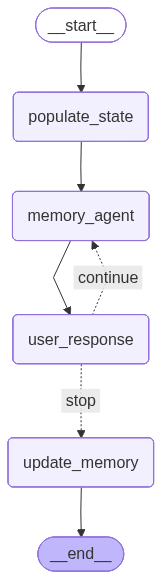

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# ========= Running the Graph =========
print("Graph compiled. Running the agent.")
print("Type 'exit' to end the conversation and save memories.")

try:
    output = graph.invoke({"messages": [""]})
    print("\nConversation ended. Final state:")
    print(output)
except Exception as e:
    print(f"\nAn error occurred while running the graph: {e}")
    print("Please ensure Ollama and Weaviate are running and accessible.")

Graph compiled. Running the agent.
Type 'exit' to end the conversation and save memories.

AI:  Hello Utkarsh! What can we work on today?  

Just to make sure we’re on the same page, could you let me know what your overall goal is right now (e.g., mastering a particular concept, preparing for an exam, coding a project, etc.)? Once I have that, we can set a concrete micro‑goal for this session. Did that help?

AI:  Sure thing!  
**Quick check:** Are you looking to understand decoders for a specific project, an exam, or just to get the big picture? Knowing that helps me tailor the details.

---

## What a Transformer Decoder Does

1. **Structure**  
   - A decoder is made up of **N identical layers** (often **N = 6**).  
   - Each layer has **three main sub‑layers**:  
     1. **Masked self‑attention** – the decoder looks only at its own previous outputs (never at future tokens).  
     2. **Encoder‑decoder attention** – the decoder can “peek” at all positions of the encoder’s output.  


In [23]:
# ========= Running the Graph =========
print("Graph compiled. Running the agent.")
print("Type 'exit' to end the conversation and save memories.")

try:
    output = graph.invoke({"messages": [""]})
    print("\nConversation ended. Final state:")
    print(output)
except Exception as e:
    print(f"\nAn error occurred while running the graph: {e}")
    print("Please ensure Ollama and Weaviate are running and accessible.")

Graph compiled. Running the agent.
Type 'exit' to end the conversation and save memories.

AI:  Hello Utkarsh! 👋

It looks like we’re just starting out. Could you let me know what your overall goal is for this session? For example, are you looking to review a specific topic, practice problems, or build a project? Once we know that, I’ll set a concrete micro‑goal so we can track your progress. 

What would you like to focus on today?

=== Updated Episodic Memory (Weaviate) ===
Weak Topics Added: []
Strong Topics Added: []

=== Updated Procedural Memory (.txt file) ===

Conversation ended. Final state:
{'messages': [SystemMessage(content='You are "STUDY-BUDDY", a helpful AI Assistant for learning and revision.\n\n    \n        ALWAYS greet the user by their name, "Utkarsh".\n        Example: "Hello Utkarsh! What can we work on today?"\n        \n\n    Here is a summary of your last relevant conversation with this user:\n    - Initial conversation setup.\n\n    Based on past sessions, her